In [1]:
import glob
import os
import time
import random

import numpy as np
import pandas as pd
import PIL

from sklearn.model_selection import StratifiedKFold

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map

import torch
from torch.utils.data.dataset import Dataset
import torch.cuda.amp as amp

import albumentations as A
from albumentations.pytorch import ToTensorV2

from map_boxes import mean_average_precision_for_boxes

In [2]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

In [3]:
NFL_ROOT_DIR = "C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/"
TRAINING_DATA = os.path.join(NFL_ROOT_DIR,"train_labels.csv")
DATA_DIR = os.path.join(NFL_ROOT_DIR,"train_frames")

train_df = pd.read_csv(TRAINING_DATA)
labels = train_df["label"].unique()
NAME_TO_LABEL_MAP = {}
label_int_id = 0
for ind,key in enumerate(labels):
    if(key[1:] not in NAME_TO_LABEL_MAP):
        NAME_TO_LABEL_MAP[key[1:]]=int(key[1:]) 
FOLDS = 5
SIZE = (512,512)
NUM_CLASSES = len(labels)
BATCHSIZE = 16
SEED = 420
MODEL_NAME = "tf_efficientdet_d1"
ORIGINAL_IMAGE_WIDTH = 1280
ORIGINAL_IMAGE_HEIGHT = 720

In [4]:
# Make results reproducible
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)


In [5]:
print(NAME_TO_LABEL_MAP)


def get_int_label(row):
    return NAME_TO_LABEL_MAP[row["label"][1:]]


{'90': 90, '79': 79, '97': 97, '72': 72, '50': 50, '34': 34, '68': 68, '5': 5, '99': 99, '30': 30, '73': 73, '56': 56, '74': 74, '96': 96, '86': 86, '36': 36, '87': 87, '59': 59, '15': 15, '27': 27, '13': 13, '22': 22, '81': 81, '70': 70, '54': 54, '67': 67, '51': 51, '2': 2, '26': 26, '65': 65, '95': 95, '82': 82, '55': 55, '85': 85, '29': 29, '21': 21, '00': 0, '24': 24, '14': 14, '25': 25, '71': 71, '28': 28, '12': 12, '17': 17, '35': 35, '69': 69, '94': 94, '61': 61, '8': 8, '76': 76, '53': 53, '19': 19, '20': 20, '23': 23, '38': 38, '11': 11, '33': 33, '44': 44, '31': 31, '52': 52, '75': 75, '89': 89, '37': 37, '32': 32, '57': 57, '46': 46, '91': 91, '10': 10, '40': 40, '58': 58, '93': 93, '88': 88, '42': 42, '60': 60, '62': 62, '77': 77, '39': 39, '83': 83, '4': 4, '98': 98, '1': 1, '18': 18, '78': 78, '3': 3, '64': 64, '92': 92, '48': 48, '6': 6, '47': 47, '84': 84, '63': 63, '43': 43, '66': 66, '16': 16, '41': 41, '80': 80, '49': 49, '9': 9, '45': 45, '7': 7}


In [6]:
train_df["int_label"] = train_df.apply(get_int_label, axis=1)


In [7]:
train_df.head()

,video_frame,gameKey,playID,view,video,frame,label,left,width,top,height,impactType,isDefinitiveImpact,isSidelinePlayer,int_label
0,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H90,245,21,327,29,None,False,False,90
1,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V79,310,21,345,12,None,False,False,79
2,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H97,410,21,323,29,None,False,False,97
3,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,None,False,False,72
4,57583_000082_Endzone_1,57583,82,Endzone,57583_000082_Endzone.mp4,1,H50,518,21,212,28,None,False,False,50


In [8]:
def get_img_path(row):
    img_id = row["video_frame"]
    path = os.path.join(DATA_DIR,img_id+".jpg")
    return path

In [9]:
train_df["path"] = train_df.apply(get_img_path, axis=1)
train_df = train_df.sample(10000)

In [10]:
final_dict = {"video_frame":[],"boxes":[],"class":[],"path":[]}
def return_bbox_dict(row):
    return [row["left"],row["top"],row["width"],row["height"],row["int_label"]]

def join_boxes_per_frame(row):
    if(row["video_frame"] not in final_dict["video_frame"]):
#         final_dict["boxes"] = []
#     if("boxes" not in ):
#         final_dict[row["video_frame"]]["boxes"] = {}    
#     final_dict[row["video_frame"]]["boxes"][row["int_label"]] = 
        final_dict["video_frame"].append(row["video_frame"])
        final_dict["class"].append(row["view"])  
        final_dict["boxes"].append([return_bbox_dict(row)])
        final_dict["path"].append(row["path"])
    else:
        index_to_update = final_dict["video_frame"].index(row["video_frame"])
        final_dict["boxes"][index_to_update].append(return_bbox_dict(row))
        
train_df.apply(join_boxes_per_frame,axis = 1)
train_samples_df = pd.DataFrame(final_dict)

In [11]:
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
train_df["fold"] = -1
for fold, (train_idx, val_idx) in enumerate(
    skf.split(X=train_samples_df["video_frame"],y=train_samples_df["class"])
):
    train_samples_df.loc[train_samples_df.iloc[val_idx].index, "fold"] = fold

In [12]:
train_samples_df.set_index("video_frame",inplace=True)

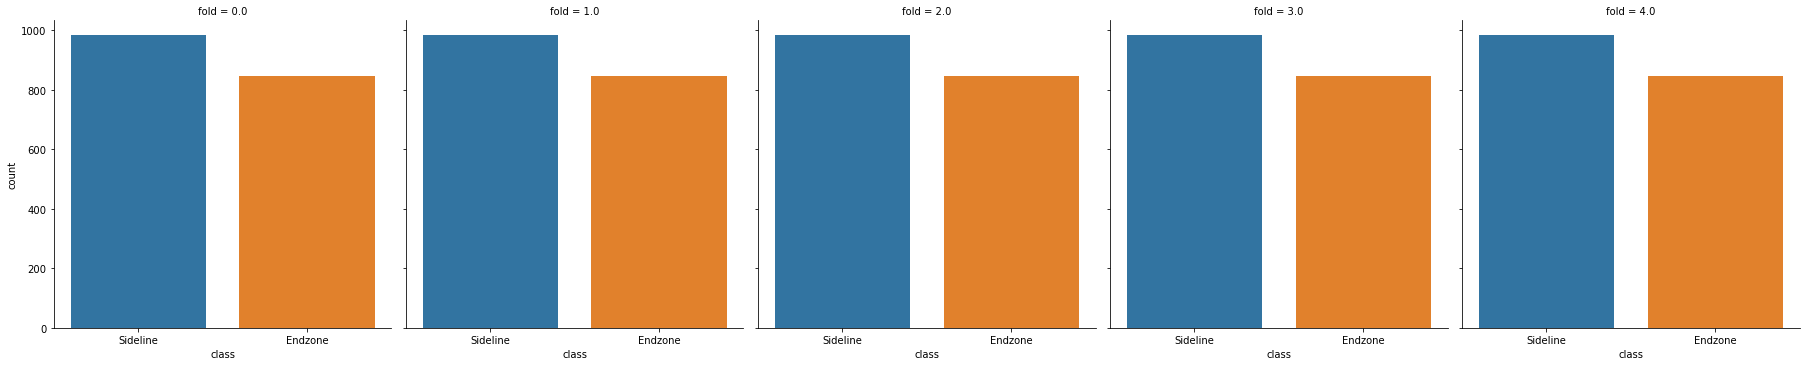

In [13]:
sns.catplot(x="class", col="fold", data=train_samples_df, kind="count")

In [14]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev


device(type='cuda')

In [33]:
class NFLDatasetFromDFHelmetAnnotations(Dataset):
    def __init__(
        self,
        df,
        train=True,
        predict=True,
        augment=True,
        data_dir=NFL_ROOT_DIR,
        size=SIZE,
    ):
        self.df = df
        self.label_list = NAME_TO_LABEL_MAP
        self.ids = df.index.sort_values()#[:100]
        self.path_suffix = data_dir
        self._augment = augment
        self._train = train
        self._predict = predict
        self._size = size
        self._transform_list = [
            # A.Resize(size[0], size[1], p=1)
        ]

        if self._augment:
            self._transform_list.extend(
                [
                    A.VerticalFlip(p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.ShiftScaleRotate(
                        scale_limit=0.20,
                        rotate_limit=10,
                        shift_limit=0.1,
                        p=0.5,
                        border_mode=cv2.BORDER_CONSTANT,
                        value=0,
                    ),
                    A.RandomBrightnessContrast(p=0.5),
                    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    # ToTensorV2(),
                ]
            )

        if self._train or self._predict:
            self._transform_list.extend(
                [
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2(),
                ]
            )

        if self._transform_list:

            self._transforms = A.Compose(
                self._transform_list,
                bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]),
            )
        self._preprocess_boxes()

    def _preprocess_boxes(self):
        self.id_bbox_map = {}
        scaled_w = self._size[1]
        scaled_h = self._size[0]
        opacity_count = 0
        none_count = 0
        for i, id in enumerate(self.ids):
            row = self.df.loc[id]
            all_boxes = []
            all_cats = []
            boxes = row["boxes"]
            for annotation in boxes:
                box = {}
                #left,top,width,height
                # convert to center and normalize to 0, 1
                box["x"] = (max(0, annotation[0])) * scaled_w / (ORIGINAL_IMAGE_WIDTH) 
                box["y"] = (max(0, annotation[1])) * scaled_h / (ORIGINAL_IMAGE_HEIGHT)
                box["width"] = annotation[2] * scaled_w / ORIGINAL_IMAGE_WIDTH
                box["height"] = annotation[3] * scaled_h / ORIGINAL_IMAGE_HEIGHT
                bbox = [
                    box["x"],
                    box["y"],
                    box["x"] + (box["width"]),
                    box["y"] + (box["height"]),
                ]

                all_boxes.append(bbox)
                all_cats.append(annotation[-1])
            self.id_bbox_map[id] = (all_boxes, all_cats)


    def __len__(self):
        return len(self.ids)

    def draw_bbox_idx(self, idx):
        img_id = self.ids[idx]
        row = self.df.loc[img_id]
        print(img_id)
        image = PIL.Image.open(row["path"])
        scaled_w = image.width
        scaled_h = image.height
        print((scaled_w, scaled_h))
        boxes = row["boxes"]
        draw = PIL.ImageDraw.Draw(image)
        for annotation in boxes:
            box = {}
            box["x"] = annotation[0] / 1280
            box["y"] = annotation[1] / 720
            box["width"] =annotation[2] / 1280
            box["height"] = annotation[3] / 720
            draw.rectangle(
                [
                    box["x"] * scaled_w,
                    box["y"] * scaled_h,
                    (box["x"] + box["width"]) * scaled_w,
                    (box["y"] + box["height"]) * scaled_h,
                ]
            )
        return image

    def _yolo_to_voc_format(self, yolo_bboxes):
        # takes in bounding boxes of the yolo format
        # converts them to voc format.
        # yolo format (x_c, y_c, width, height) normalized to 0, 1 by dividing by image dims.
        # voc format (x_min, y_min, x_max, y_max), unnormalized.
        scaled_w = self._size[1]
        scaled_h = self._size[0]
        bboxes_voc = torch.zeros_like(yolo_bboxes)
        # x_min = (x_c - width / 2) * scaled_w
        bboxes_voc[:, 0] = (yolo_bboxes[:, 0] - yolo_bboxes[:, 2] / 2) * scaled_w
        bboxes_voc[:, 1] = (yolo_bboxes[:, 1] - yolo_bboxes[:, 3] / 2) * scaled_h
        bboxes_voc[:, 2] = bboxes_voc[:, 0] + yolo_bboxes[:, 2] * scaled_w
        bboxes_voc[:, 3] = bboxes_voc[:, 1] + yolo_bboxes[:, 3] * scaled_h

        return bboxes_voc

    def draw_bbox_img(self, image, bboxes, label):
        image = PIL.Image.fromarray(image)
        draw = PIL.ImageDraw.Draw(image)
        for bbox in bboxes:
            # x_c = bbox[0]
            # y_c = bbox[1]
            # width = bbox[2]
            # height = bbox[3]
            # x_1 = (x_c - width / 2) * image.width
            # y_1 = (y_c - height / 2) * image.height
            # x_2 = x_1 + width * image.width
            # y_2 = y_1 + height * image.height
            # draw.rectangle([x_1, y_1, x_2, y_2])
            draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])
        print(f"Number of boxes{len(label)}")
        return image

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        boxes, labels = self.id_bbox_map[img_id]
        row = self.df.loc[img_id]

        path = row["path"]
        # ideally, we'd clean up the df,
        # but may be we use it to produce predictions as well.
        dicom_arr = cv2.imread(path)
        img = cv2.cvtColor(dicom_arr, cv2.COLOR_BGR2RGB)
        image_and_labels = {}
        if self._augment or (self._train or self._predict):
            image_and_labels = self._transforms(image=img, bboxes=boxes, labels=labels)
        else:
            image_and_labels = {"image": img, "bboxes": boxes, "labels": labels}

        # image_and_labels["bboxes"] = self._yolo_to_voc_format(
        #     torch.tensor(image_and_labels["bboxes"])
        # )

        if not image_and_labels["bboxes"]:
            w = torch.rand(1) * 10
            h = torch.rand(1) * 10
            image_and_labels["bboxes"] = [[self._size[0] /2 - w, self._size[1]/2 - h, self._size[0]/2 + w, self._size[1]/2 + h]]
            image_and_labels["labels"] = [-1]
        # print(image_and_labels["bboxes"].shape)
        image_and_labels["bboxes"] = torch.tensor(image_and_labels["bboxes"]).to(dtype=torch.float32)
        image_and_labels["labels"] = torch.tensor(image_and_labels["labels"]).to(dtype=torch.long)

        return image_and_labels


In [34]:
training_ds = NFLDatasetFromDFHelmetAnnotations(
    train_samples_df, train=False, predict=False, augment=True, size=SIZE
)


57583_000082_Sideline_201
(512, 512)


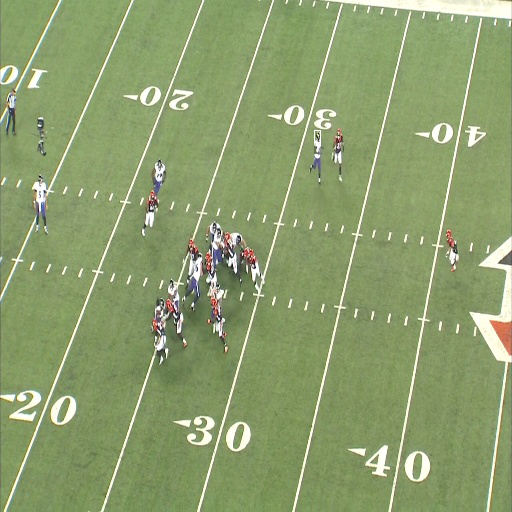

In [35]:
training_ds.draw_bbox_idx(100)

In [37]:
make_gt_df_from_ds(training_ds)

C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_101.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_102.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_109.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_119.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_121.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_125.jpg
C:/Users/K

C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_91.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Endzone_97.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_105.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_106.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_108.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_109.jpg
C:/Users

C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_314.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_321.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_325.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_326.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_329.jpg
C:/Users/Kashyap/bkp/source/repos/efficient-det-siim-covid-19-challenge/kaggle-nfl/nfl-health-and-safety-helmet-assignment/train_frames\57583_000082_Sideline_337.jpg
C:/U

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-sn_xpupm\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [18]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [19]:
def train_epoch(
    epoch,
    step,
    dataloader,
    batchsize,
    model_w_loss,
    optimizer,
    log_every=10,
    scaler=None,
):

    steps = len(dataloader)
    batchsize = batchsize
    dataiter = iter(dataloader)

    time_now = time.time()

    total_loss_avg = AverageMeter()
    cls_loss_avg = AverageMeter()
    reg_loss_avg = AverageMeter()

    model_w_loss.train()
    loader = tqdm(range(steps))

    enable_autocast = not (scaler == None)

    for i in loader:
        optimizer.zero_grad()
        data = next(dataiter)
        images, bboxes, labels = data["image"], data["bboxes"], data["labels"]

        images = images.to(dev)

        bboxes = [bbox.float().to(dev) for bbox in bboxes]
        labels = [label.to(dev) for label in labels]

        with amp.autocast(enabled=enable_autocast):
            # hacky timm target assembly
            target = {"bbox": bboxes, "cls": labels}
            losses = model_w_loss(images, target)
            cls_loss, reg_loss = losses["class_loss"], losses["box_loss"]
            # cls_loss = cls_loss.mean()
            # reg_loss = reg_loss.mean()
            loss = losses["loss"]

        if enable_autocast:
            scaled_loss = scaler.scale(loss)
            scaled_loss.backward()
        else:
            total_loss_avg.update(loss.item(), batchsize)
            loss.backward()
        total_loss_avg.update(loss.item(), batchsize)
        cls_loss_avg.update(cls_loss.item(), batchsize)
        reg_loss_avg.update(reg_loss.item(), batchsize)

        if scaler:
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()

        time_spent = time.time() - time_now
        time_now = time.time()

        loader.set_description(
            "Training Epoch : {}, Time Spent {:.5g}, Step {}".format(
                epoch, time_spent, step
            )
        )
        loader.set_postfix(
            loss=total_loss_avg.avg,
            reg_loss=reg_loss_avg.avg,
            cls_loss=cls_loss_avg.avg,
        )

        step += 1

    return cls_loss_avg.avg, reg_loss_avg.avg, total_loss_avg.avg, step


In [20]:
def normalize_boxes_in_df(boxes_df):
    boxes_df["XMin"] = boxes_df["XMin"] / SIZE[0]
    boxes_df["YMin"] = boxes_df["YMin"] / SIZE[1]
    boxes_df["XMax"] = boxes_df["XMax"] / SIZE[0]
    boxes_df["YMax"] = boxes_df["YMax"] / SIZE[1]
    return boxes_df

In [21]:
def valid_epoch(epoch, step, dataloader, batchsize, model_w_loss, gt_df):
    num_val = len(dataloader)

    dataiter = iter(dataloader)
    model_w_loss.eval()

    detections = []

    total_loss_avg = AverageMeter()
    cls_loss_avg = AverageMeter()
    reg_loss_avg = AverageMeter()

    with torch.no_grad():
        for i in tqdm(range(num_val)):
            data = next(dataiter)
            images, bboxes, labels = data["image"], data["bboxes"], data["labels"]
            batchsize = images.shape[0]

            images = images.to(dev)

            bboxes = [bbox.float().to(dev) for bbox in bboxes]
            labels = [label.to(dev) for label in labels]
            target = {
                "bbox": bboxes,
                "cls": labels,
                "img_scale": torch.tensor(
                    [1.0] * images.shape[0], dtype=torch.float32
                ).to(dev),
                "img_size": torch.tensor(
                    [images.shape[-2:]] * images.shape[0], dtype=torch.float32
                ).to(dev),
            }
            losses_w_detections = model_w_loss(images, target)
            cls_loss, reg_loss = (
                losses_w_detections["class_loss"],
                losses_w_detections["box_loss"],
            )
            loss = losses_w_detections["loss"]
            total_loss_avg.update(loss.item(), batchsize)
            cls_loss_avg.update(cls_loss.item(), batchsize)
            reg_loss_avg.update(reg_loss.item(), batchsize)

            batched_detections = losses_w_detections["detections"]
            detections.append(batched_detections)

        offset = 0
        ids = dataloader.dataset.ids
        label_list = dataloader.dataset.label_list
        all_preds = []
        for batched_detections in detections:
            num_imgs, num_dets_per_img = (
                batched_detections.shape[0],
                batched_detections.shape[1],
            )
            img_ids = []

            for i in range(num_imgs):
                img_ids.extend([ids[offset]] * num_dets_per_img)
                offset += 1

            batched_preds_df = pd.DataFrame.from_records(
                batched_detections.view(num_imgs * num_dets_per_img, -1).tolist(),
                columns=["XMin", "YMin", "XMax", "YMax", "Conf", "LabelName"],
            )
            batched_preds_df["ImageID"] = img_ids
            batched_preds_df["LabelName"] = batched_preds_df.apply(
                lambda x: label_list[int(x["LabelName"] - 1)], axis=1
            )
            all_preds.append(batched_preds_df)
        all_preds_df = pd.concat(all_preds)
        print(all_preds_df.columns)
        print(gt_df.columns)

        # gt_df = normalize_boxes_in_df(gt_df)
        # all_preds_df = normalize_boxes_in_df(all_preds_df)

        mean_ap, average_precisions = mean_average_precision_for_boxes(
            gt_df[["ImageID", "LabelName", "XMin", "XMax", "YMin", "YMax"]],
            all_preds_df[
                ["ImageID", "LabelName", "Conf", "XMin", "XMax", "YMin", "YMax"]
            ],
            verbose=True,
        )
    # topk = (-probs).argsort(axis=1)[:, :2]
    # # mapk = mean_average_precision(targets[:, np.newaxis].tolist(), topk.tolist(), k=2)
    print("Mean AP @0.5 Score at Epoch {} and Step {}: {}".format(epoch, step, mean_ap))
    print(
        "AP @0.5 Score for Opacity at Epoch {} and Step {}: {}".format(
            epoch, step, average_precisions["opacity"]
        )
    )
    # print("AUC Score at Epoch {} and Step {}: {}".format(epoch, step, auc))
    return (
        average_precisions["none"][0],
        total_loss_avg.avg,
        cls_loss_avg.avg,
        reg_loss_avg.avg,
        average_precisions["opacity"][0],
        all_preds_df
    )


In [22]:
def train_model(
    model_w_loss,
    epochs,
    batchsize,
    optimizer,
    scheduler,
    save_path,
    train_dl,
    validation_dl,
    val_gt_df,
    use_mp=True,
):
    if use_mp:
        scaler = amp.GradScaler()
    else:
        scaler = None
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    train_vs_val = []

    reg_loss_best = float("inf")
    mean_ap_best = -float("inf")
    ap_opacity_best = -float("inf")
    step = 0

    for epoch in range(epochs):

        train_cls_loss, train_reg_loss, train_total_loss, step = train_epoch(
            epoch, step, train_dl, batchsize, model_w_loss, optimizer, scaler=scaler
        )

        time_now = time.time()
        (
            mean_ap,
            val_total_loss,
            val_cls_loss,
            val_reg_loss,
            ap_opacity,
            preds_df,
        ) = valid_epoch(epoch, step, validation_dl, batchsize, model_w_loss, val_gt_df)
        # val_mapk, val_auc, val_loss_avg, probs, targets = valid_epoch(
        #     epoch, step, validation_dl, batchsize * 2, model, loss_fn
        # )

        train_vs_val.extend(
            [
                (epoch, mean_ap, "Mean AP"),
                (epoch, ap_opacity, "Validation AP Opacity"),
                (epoch, val_total_loss, "Validation Total Loss"),
                (epoch, val_reg_loss, "Train Regression Loss"),
                (epoch, val_cls_loss, "Train Classification Loss"),
                (epoch, train_total_loss, "Training Total Loss"),
                (epoch, train_reg_loss, "Train Regression Loss"),
                (epoch, train_cls_loss, "Train Classification Loss"),
            ]
        )

        if scheduler:
            scheduler.step(val_total_loss)
            print(
                "Setting Learning Rate to: {:.6f}".format(
                    optimizer.param_groups[-1]["lr"]
                )
            )

        if reg_loss_best > val_reg_loss:
            print(
                "Found Model with best Regression Loss {} at epoch {}".format(
                    val_reg_loss, epoch
                )
            )
            torch.save(
                {
                    "epoch": epoch,
                    "mAP": mean_ap,
                    "TotalLoss": val_total_loss,
                    "AP (Opacity)": ap_opacity,
                    "state_dict": model_w_loss.module.model.state_dict(),
                },
                os.path.join(save_path, "best_reg_loss.pth"),
            )
            preds_df.to_csv(
                os.path.join(save_path, "best_reg_loss_preds.csv"), index=False
            )
            reg_loss_best = val_reg_loss

        if reg_loss_best > val_total_loss:
            print(
                "Found Model with best Total Loss {} at epoch {}".format(
                    val_total_loss, epoch
                )
            )
            torch.save(
                {
                    "epoch": epoch,
                    "mAP": mean_ap,
                    "TotalLoss": val_total_loss,
                    "AP (Opacity)": ap_opacity,
                    "state_dict": model_w_loss.module.model.state_dict(),
                },
                os.path.join(save_path, "best_total_loss.pth"),
            )
            preds_df.to_csv(
                os.path.join(save_path, "best_total_loss_preds.csv"), index=False
            )
            reg_loss_best = val_total_loss

        if ap_opacity_best < ap_opacity:
            print(
                "Found Model with best AP Opacity {} at epoch {}".format(
                    ap_opacity, epoch
                )
            )
            torch.save(
                {
                    "epoch": epoch,
                    "mAP": mean_ap,
                    "TotalLoss": val_total_loss,
                    "AP (Opacity)": ap_opacity,
                    "state_dict": model_w_loss.module.model.state_dict(),
                },
                os.path.join(save_path, "best_ap_opacity.pth"),
            )
            ap_opacity_best = ap_opacity
            preds_df.to_csv(
                os.path.join(save_path, "best_ap_opacity_preds.csv"), index=False
            )

        if mean_ap_best < mean_ap:
            print("Found Model with best Mean AP {} at epoch {}".format(mean_ap, epoch))
            torch.save(
                {
                    "epoch": epoch,
                    "mAP": mean_ap,
                    "TotalLoss": val_total_loss,
                    "AP (Opacity)": ap_opacity,
                    "state_dict": model_w_loss.module.model.state_dict(),
                },
                os.path.join(save_path, "best_mean_ap.pth"),
            )
            mean_ap_best = mean_ap
            preds_df.to_csv(
                os.path.join(save_path, "best_mean_ap_preds.csv"), index=False
            )

        time_spent = time.time() - time_now
        print(
            "{}, Epoch : {}, Step : {}, Validation Loss : {:.5f}, Mean AP : {:.5f}, AP Opacity : {:.5f}, Run Time : {:.5g}".format(
                time.strftime("%Y-%m-%d %H:%M:%S"),
                epoch,
                step,
                val_total_loss,
                mean_ap,
                ap_opacity,
                time_spent,
            )
        )

    return train_vs_val


In [23]:
def collater(data):
    imgs = [s["image"] for s in data]
    bboxes = []
    labels = []
    for i, s in enumerate(data):
        # if len(s["bboxes"].shape) != 2:
        #     print("came here")
        #     width = torch.rand(1) * 10
        #     height = torch.rand(1) * 10
        #     bboxes.append(torch.rand((4)) * 10)
        #     labels.append(torch.tensor([[1]]))
        # else:
            # rearrange to timm format
        bboxes.append(s["bboxes"][:, [1, 0, 3, 2]])
        labels.append(s["labels"])
    # labels = [s["labels"] for s in data]

    imgs = torch.stack(imgs, dim=0)

    max_boxes = max(bbox.shape[0] for bbox in bboxes)

    # if max_boxes > 0:

    #     annot_padded = torch.ones((len(bboxes), max_boxes, 4)) * -1

    #     for idx, annot in enumerate(bboxes):
    #         if annot.shape[0] > 0:
    #             annot_padded[idx, :annot.shape[0], :-1] = annot
    #             annot_padded[idx, :annot.shape[0], -1] = labels[idx]
    # else:
    #     annot_padded = torch.ones((len(bboxes), 1, 5)) * -1

    # imgs = imgs.permute(0, 3, 1, 2)

    return {"image": imgs, "bboxes": bboxes, "labels": labels}



In [27]:
def make_gt_df_from_ds(dataset):
    label_list = dataset.label_list
    gt_df = []
    for i, data in enumerate(dataset):
        print(data)
        bboxes = data["bboxes"].tolist()
        labels = data["labels"].tolist()
        id = dataset.ids[i]
        for j, box in enumerate(bboxes):
            box.extend([labels[j], id])
        
        img_df = pd.DataFrame.from_records(
            bboxes, columns=["XMin", "YMin", "XMax", "YMax", "LabelName", "ImageID"]
        )
        gt_df.append(img_df)
    print(pd.concat(gt_df).columns)
    gt_df = pd.concat(gt_df)
    gt_df["LabelName"] = gt_df.apply(lambda x: label_list[int(x["LabelName"] - 1)], axis=1)
    return gt_df


In [28]:
def get_net():
    config = get_efficientdet_config(MODEL_NAME)

    config.image_size = SIZE
    config.norm_kwargs = dict(eps=0.001, momentum=0.01)

    net = EfficientDet(config, pretrained_backbone=True)
    net.reset_head(num_classes=2)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    print(config)

    return DetBenchTrain(net, config)


In [29]:
for fold in range(FOLDS):
    print("Training Fold {}".format(fold))
    model = get_net()

    model = torch.nn.DataParallel(model)
    model = model.to(dev)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=5, verbose=False, min_lr=1e-7
    )
    
    training_fold = train_samples_df[train_samples_df["fold"] != fold]
    validation_fold = train_samples_df[train_samples_df["fold"] == fold]
    
    validation_fold.to_csv("validation_fold-{}".format(fold))
    training_fold.to_csv("training_fold-{}".format(fold))
    training_ds = NFLDatasetFromDFHelmetAnnotations(
        train_samples_df[train_samples_df["fold"] != fold],
        augment=True,
        train=True,
        size=SIZE,
    )
    validation_ds = NFLDatasetFromDFHelmetAnnotations(
        train_samples_df[train_samples_df["fold"] == fold],
        predict=True,
        augment=False,
        size=SIZE,
    )

    val_df = make_gt_df_from_ds(validation_ds)
    print("{} Ground Truth size".format(str(val_df.shape)))
    print("{} train len {} val len".format(len(training_ds), len(validation_ds)))

    training_dl = torch.utils.data.DataLoader(
        dataset=training_ds,
        batch_size=BATCHSIZE,
        pin_memory=True,
        num_workers=0,
        drop_last=False,
        shuffle=True,
        collate_fn=collater,
        # prefetch_factor=8,
    )
    validation_dl = torch.utils.data.DataLoader(
        dataset=validation_ds,
        batch_size=BATCHSIZE,
        pin_memory=True,
        num_workers=0,
        shuffle=False,
        drop_last=False,
        # prefetch_factor=8,
        collate_fn=collater,
    )

    print(
        "{} training data loader size {} validation dataloader size".format(
            len(training_dl), len(validation_dl)
        )
    )

    train_vs_val = train_model(
        model_w_loss=model,
        epochs=20,
        optimizer=optimizer,
        scheduler=scheduler,
        batchsize=BATCHSIZE,
        save_path="{}-{}".format(MODEL_NAME, fold),
        train_dl=training_dl,
        validation_dl=validation_dl,
        val_gt_df=val_df,
    )

    fold_report = pd.DataFrame.from_records(
        data=train_vs_val, columns=["Epoch", "Loss", "Type"]
    )
    fold_report.to_csv("fold-{}-report.csv".format(fold), index=False)

Training Fold 0
{'name': 'tf_efficientdet_d1', 'backbone_name': 'tf_efficientnet_b1', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 2, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 4, 'fpn_channels': 88, 'separable_conv': True, 'apply_resample_bn': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nm

TypeError: 'NoneType' object is not subscriptable

In [31]:
val_df = make_gt_df_from_ds(validation_ds)

TypeError: 'NoneType' object is not subscriptable